# Preprocessing data for pipeline FaceNet + SVM

After this preprocessing step, result in `preprocessed_data` folder, we use these data to train a SVM model, see in `SVM_Classifier.ipynb` notebook.

# 1. Import, install all necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import uuid
from PIL import Image
from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed

# For the Facenet model
import torch  # Ensure torch is imported here to avoid circular import issues
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms

c:\Users\Chu Trung Anh\Desktop\Biometric_IT4432E\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create a `preprocessed_data` folderin the same location as data folder. The `preprocessed_data` folder should contain two subfolders: `face_detect` and `face_embeddings`.

1. **face_detect folder**:

- Contains extracted facial images from the original dataset

- Organized into subfolders named after each person

- Each subfolder includes:
    - Face images extracted from that person's original photos
    - A single `faces.npz` file containing numpy arrays of all facial data

Note: The individual images are for visualization only; the model works with the numpy arrays stored in the .npz file

2. **face_embeddings folder**:

Inside there are many subfolders with the name of the person, each subfolder contains a `embeddings.npz` file that stores the embeddings of that person's faces. We take input as the `faces.npz` file from a person's folder, pass it through the FaceNet model to get the embeddings, and store them in the `embeddings.npz` file in corresponding subfolders named after the person.

The pipeline look something like this:

![DataFolderStructure.drawio.png](./assets/images/DataFolderStructure.drawio.png)

For more detail, we will use the images of faces inside `data` folder as input for the face detection algorithm. The algorithm takes a  the input image and detects faces in each image within the training folders, generating a .npz file which is a file format used in Python for storing and retrieving large numerical arrays and matrices.

For the face detection task in our system, we will be employing the MTCNN algorithm, which stands for Multi-Task Cascaded Convolutional Neural Network. This deep learning algorithm is commonly used for face detection and facial recognition tasks. MTCNN uses a cascading approach to detect faces and facial features such as the eyes, nose, and mouth. 


In this task, we will create a folder name `preprocessed_data` at the same level as the `data` folder. The `preprocessed_data` folder will contain two subfolders: face_detect and face_embeddings.

- The `face_detect` folder will contain the images with the faces extracted from the original images. Inside there are many subfolder with the name of the person, each subfolder contains the images of faces extracted from that person images. Also, compressed all faces imgages inside a subfolder into a single .npz file inside that subfolder. (Actually, the faces images are just for visualization, the model will just need to read the faces represents by numpy arrays in the .npz file to work with).

- The `face_embeddings` folder will contain the .npz files that contain the embeddings of the faces. Each .npz file will contain the embeddings of the faces of a specific person. The embeddings are generated by a pre-trained model, in this case, we will use the FaceNet model. The FaceNet model is a deep learning model that generates embeddings for faces. The embeddings are numerical representations of the faces that can be used for face recognition tasks.


In [2]:
# Create preprocessed_data folder
os.makedirs('preprocessed_data', exist_ok=True)

# Inside that folder, create face_detect folder and face_embeddings folder
os.makedirs(os.path.join('preprocessed_data', 'face_detect'), exist_ok=True)
os.makedirs(os.path.join('preprocessed_data', 'face_embeddings'), exist_ok=True)

# The final outcome of this notebook will be the embeddings of the faces in the dataset, meanin the face_embeddings folder. The face_detect folder serves as an intermediate step to store the extracted faces from the images.

# 2. Face Detection

In [3]:
### Now, from the `data` folder, extract end align the faces (crop image to keep only face) and save them in the `face_detect` folder ###


# Detect and extract faces from an image using MTCNN
# Parameters:
# - image_path: path to the image file
# - detector: MTCNN detector object
# - required_size: the size of the extracted face images (default is (160, 160))
def detect_and_extract_faces(image_path, detector, required_size=(160, 160)):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    detections = detector.detect_faces(image_np)
    faces = []
    for detection in detections:
        x, y, width, height = detection['box']
        face = image_np[y:y+height, x:x+width]
        face_image = Image.fromarray(face).resize(required_size)
        faces.append(np.array(face_image))
    return faces

# Process a single subfolder (since the data folder contains subfolders for each person, use this function to process each subfolder)
# Parameters:
# - subfolder: the subfolder name in data folder we want to process
# - face_only_dataset_dir: the directory to save the extracted faces. This is the subfolder with person's name inside the face_detect folder

# - detector: MTCNN detector object
def process_subfolder(subfolder, face_only_dataset_dir, detector):
    subfolder_path = os.path.join('./data', subfolder) #Acessing the subfolder
    new_faces_folder = os.path.join(face_only_dataset_dir, os.path.basename(subfolder))
    
    # Create the new_faces_folder if it does not exist
    os.makedirs(new_faces_folder, exist_ok=True)
    
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg')] # For all images inside a person folder in the subfolder 
    faces = []
    
    for image_file in image_files:
        image_path = os.path.join(subfolder_path, image_file)
        extracted_faces = detect_and_extract_faces(image_path, detector)
        
        for i, face in enumerate(extracted_faces):
            face_image = Image.fromarray(face)
            face_image_path = os.path.join(new_faces_folder, f'{os.path.splitext(image_file)[0]}_face_{i+1}.jpg')
            face_image.save(face_image_path)
        
        faces.extend(extracted_faces)
    
    # Ensure all faces have the same shape before saving to .npz
    if faces:
        face_shape = faces[0].shape
        faces = [face for face in faces if face.shape == face_shape]
        faces = np.array(faces)
        savez_compressed(os.path.join(new_faces_folder, 'faces.npz'), faces)



`faces.npz` is just simply a compressed file that contains all list of numpy arrays, where each numpy array is a face image. 

In [ ]:

# Main function to process all subfolders

detector = MTCNN()

# Except the README file, process all subfolders

for subfolder in os.listdir('./data'):
    if subfolder == 'README.md':
        continue
    print("Processing face detection for:", subfolder)
    process_subfolder(subfolder, './preprocessed_data/face_detect', detector)

Processing face detection for: Alistair_MacDonald
Processing face detection for: Andrew_Wetzler
Processing face detection for: Bruce_Gebhardt
Processing face detection for: Charles_Schumer
Processing face detection for: Connie_Freydell
Processing face detection for: David_Duval
Processing face detection for: Gianna_Angelopoulos-Daskalaki


First subfolder: Alistair_MacDonald
Keys in the .npz file: ['arr_0']
Shape of faces array: (12, 160, 160, 3)
Shape of the first face: (160, 160, 3)


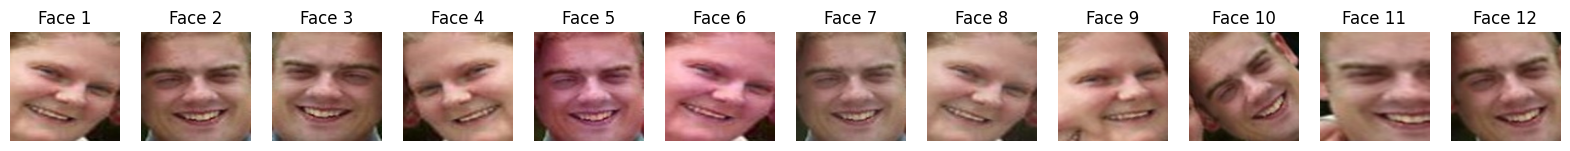

In [ ]:
# Testing: load a faces.npz file in the first subfolder and display the faces

# When commit to github, some folders are empty, so to remain the visualizatoin code structure,
# I add .gitkeep file to these folders. These .gitkeep are just for display purpose and have no meaning in the code.
# Therefore, if you get any error related to .gitkeep when run my code, you can just simply delete it to fix the error.

# Get the path to the first subfolder, excluding .gitkeep
subfolders = [f for f in os.listdir('./preprocessed_data/face_detect') if f != '.gitkeep']
first_subfolder = subfolders[0] if subfolders else None

if first_subfolder:
    print("First subfolder:", first_subfolder)

    # Load the .npz file
    npz_file_path = os.path.join('./preprocessed_data/face_detect', first_subfolder, 'faces.npz')
    test = np.load(npz_file_path)

    # Print the keys in the .npz file
    print("Keys in the .npz file:", test.files)

    # Extract the faces array
    faces = test['arr_0']

    # Print the shape of the faces array
    print("Shape of faces array:", faces.shape)

    # Print the shape of the first face
    face_shape = faces[0].shape
    print("Shape of the first face:", face_shape)

    # Plot the faces
    plt.figure(figsize=(20, 5))
    for i, face in enumerate(faces):
        plt.subplot(1, len(faces), i+1)
        plt.axis('off')
        plt.title(f"Face {i+1}")
        plt.imshow(face)
    plt.show()
else:
    print("No valid subfolders found.")

# 3. Features Extraction

Face feature extraction is a crucial step in face recognition systems. It involves transforming the raw image data of a face into a high-dimensional feature vector, which can be used to represent the unique facial characteristics of an individual. The feature extraction process aims to identify the most informative and discriminative facial features, such as the shape, texture, and color of facial components like eyes, nose, and mouth.

In our system we will use FaceNet algorithm which is a deep learning algorithm used for feature extraction in face recognition systems. Make sure you already run the following command that I put at te beginning of the notebook to install the necessary model. In this case, we use te Facenet model from Pytorch. It may take a while to download the model, so be patient.

In [6]:
# Load the pre-trained FaceNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Define a function to generate embeddings
# Parameters:
# - image_array: a numpy array representing the image
def generate_embedding(image_array):
    # Convert numpy array to PIL image
    image = Image.fromarray(image_array)
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    # Generate embedding
    with torch.no_grad():
        embedding = model(img_tensor).cpu().numpy()
    return embedding

# Process a single subfolder
# Parameters:
# - subfolder: the subfolder name in face_only_dataset we want to process
# - embedding_dir: the directory to save the embeddings. This is the subfolder with person's name inside the face_embeddings folder
def process_subfolder_for_embeddings(subfolder, embedding_dir):
    
    # Skip .gitkeep files
    if subfolder == '.gitkeep':
        return

    subfolder_path = os.path.join('./preprocessed_data/face_detect', subfolder)
    new_embedding_folder = os.path.join(embedding_dir, os.path.basename(subfolder))
    
    os.makedirs(new_embedding_folder, exist_ok=True)
    
    # Load faces from the .npz file
    data = np.load(os.path.join(subfolder_path, 'faces.npz'))
    faces = data['arr_0']
    
    embeddings = []
    
    for face in faces:
        embedding = generate_embedding(face)
        embeddings.append(embedding)
    
    # Save embeddings to a .npz file
    embeddings = np.array(embeddings)
    savez_compressed(os.path.join(new_embedding_folder, 'embeddings.npz'), embeddings)



In [ ]:
# Main function to process all subfolders
for subfolder in os.listdir('./preprocessed_data/face_detect'):
    print("Extracted features for:", subfolder)
    process_subfolder_for_embeddings(subfolder, './preprocessed_data/face_embeddings')

Extracted features for: .gitkeep
Extracted features for: Alistair_MacDonald
Extracted features for: Andrew_Wetzler
Extracted features for: Bruce_Gebhardt
Extracted features for: Charles_Schumer
Extracted features for: Connie_Freydell
Extracted features for: David_Duval
Extracted features for: Gianna_Angelopoulos-Daskalaki
Extracted features for: Hank_Azaria
Extracted features for: Hasan_Wirayuda
Extracted features for: Javier_Bardem
Extracted features for: Jeff_George
Extracted features for: Jorge_Castaneda
Extracted features for: Leslie_Moonves
Extracted features for: Marc_Shaiman
Extracted features for: Melissa_Etheridge
Extracted features for: Michael_Jasny
Extracted features for: Rachel_Hunter
Extracted features for: Rodrigo_de_la_Cerna
Extracted features for: Rogelio_Ramos
Extracted features for: Steve_Blankenship


In [11]:
# Show an example of the embeddings

# first, load the first subfolder inside the face_embeddings folder
subfolders = [f for f in os.listdir('./preprocessed_data/face_embeddings') if f != '.gitkeep']
first_subfolder = subfolders[0] if subfolders else None

# Load the .npz file
npz_file_path = os.path.join('./preprocessed_data/face_embeddings', first_subfolder, 'embeddings.npz')
test = np.load(npz_file_path)

# Print the keys in the .npz file
print("Keys in the .npz file:", test.files)

# Extract the embeddings array
embeddings = test['arr_0']

# Print the shape of the embeddings array
print("Shape of embeddings array:", embeddings.shape)

# Print the first embedding
print("First embedding:", embeddings[0])


Keys in the .npz file: ['arr_0']
Shape of embeddings array: (12, 1, 512)
First embedding: [[ 2.41659041e-02 -1.25714317e-02  1.75812449e-02 -2.60464270e-02
  -3.70359384e-02 -1.03549222e-02 -1.27668744e-02  5.04044704e-02
   1.67790744e-02 -4.75505018e-04  5.84108569e-02  2.25064103e-02
  -8.45792238e-03  3.10830679e-02  5.89710334e-03  5.72915487e-02
   3.38664912e-02 -2.38674488e-02 -3.12793404e-02 -6.20543547e-02
   1.70271769e-02 -9.24190283e-02  4.19445261e-02 -6.81056902e-02
  -4.35919650e-02 -5.23232929e-02  2.34613251e-02  1.16110401e-04
   2.23857537e-02 -1.30497832e-02 -2.84328144e-02 -2.62899492e-02
   1.86306273e-03  3.40818428e-02 -6.34654909e-02 -2.07758714e-02
  -7.54799228e-03  4.48137447e-02 -4.15390134e-02 -6.96377829e-02
  -2.18185280e-02 -7.39465607e-03 -4.49288897e-02  7.91047513e-02
   7.62268007e-02 -3.77998538e-02  8.94979225e-04 -5.52558415e-02
  -2.39381492e-02  4.52126339e-02 -8.04594904e-03  4.26269248e-02
   1.97270941e-02 -2.57691480e-02 -1.07746162e-01  3